<h2> Trabalho prático III: Detecção de fraude em cartões de crédito utilizando modelos de classificação.<h2>

<h3> 1. Introdução</h3>

<p> O conjunto de dados selecionado é referente ao histórico de fraudes em cartões de crédito de uma determinada empresa. O objetivo é determinar se alguma atividade do cartão é referente a alguma fraude ou não a partir de modelos de classificação, em seguida, avaliar os resultados.</p>

In [88]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier, plot_tree

df = pd.read_csv("card_transdata.csv", sep = ',')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


<h3> 2. Limpeza de dados e analise exploratória:</h3>

<h4> 2.2 Checando a existencia de valores nulos</h4>

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<ul><li>Nâo há valores nulos no dataset</li></ul>

<h4> 2.3 Parametros que só podem ser verdadeiros ou falsos:</h4>

In [3]:
for feature in ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']:
    print(feature,df[feature].unique(),sep=' : ')

repeat_retailer : [1. 0.]
used_chip : [1. 0.]
used_pin_number : [0. 1.]
online_order : [0. 1.]
fraud : [0. 1.]


<h4> 2.3 Verificando outliers</h4>

In [4]:
# Separando features do tipo numerico dos de tipo categóricos
numerical_features = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
categorical_features =  ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']

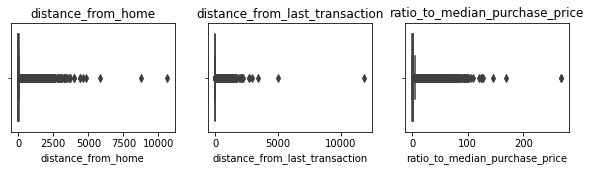

In [5]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(10,2))
position_matrix = [0,1,2]

count_var = 0

for feature in numerical_features:
    sns.boxplot(ax=axes[count_var],data=df, x=feature,hue='fraud')
    axes[position_matrix[count_var]].set_title(feature)
    count_var += 1

<ul><li>Por enquanto vamos assumir que os outlier se tratam de fraudes, pois são valores muito altos utilizados a uma distancia muito grande da casa do dono do cartão, portanto não serão removidos</li></ul>

<h4> 2.4 Descrevendo as features do dataset </h4>

<table style = 'float: center'>
<tr>
    <td style = 'text-align:left'>Coluna</td>
    <td style = 'text-align:left'>Descrição</td>
</tr>

<tr>
    <td style = 'text-align:left'> distance_from_home</td>
    <td style = 'text-align:left'> A distancia entre onde foi feita a transação e a casa do dono do cartão (em km)</td>
</tr>
    
<tr>
    <td style = 'text-align:left'> distance_from_last_transaction</td>
    <td style = 'text-align:left'> A distancia entre onde foram feitas a ultima e a atual transação (em Km)</td>
</tr>

<tr>
    <td style = 'text-align:left'> ratio_to_median_purchase_price</td>
    <td style = 'text-align:left'> A razão entre a transação mediana e a transação atual. Expelo: mediana = 50, atual = 60 então "ratio_to_median_purchase_price = 50/60 </td>
</tr>

<tr>
    <td style = 'text-align:left'> repeat_retailer</td>
    <td style = 'text-align:left'> Define se a transação está sendo feita em um lugar onde o cartão é frequentemente utilizado </td>
</tr>

<tr>
    <td style = 'text-align:left'> used_chip</td>
    <td style = 'text-align:left'> Define se a transação foi realizada utilizando um chip RFID</td>
</tr>

<tr>
    <td style = 'text-align:left'> used_pin_number</td>
    <td style = 'text-align:left'> Define se foi utilizado o numero pin na transação</td>
</tr>

<tr>
    <td style = 'text-align:left'> online_order</td>
    <td style = 'text-align:left'> Define se a transação se trata de um pagamento online</td>
</tr>
</table>

<h4> 2.5 Verificando as combinações </h4>

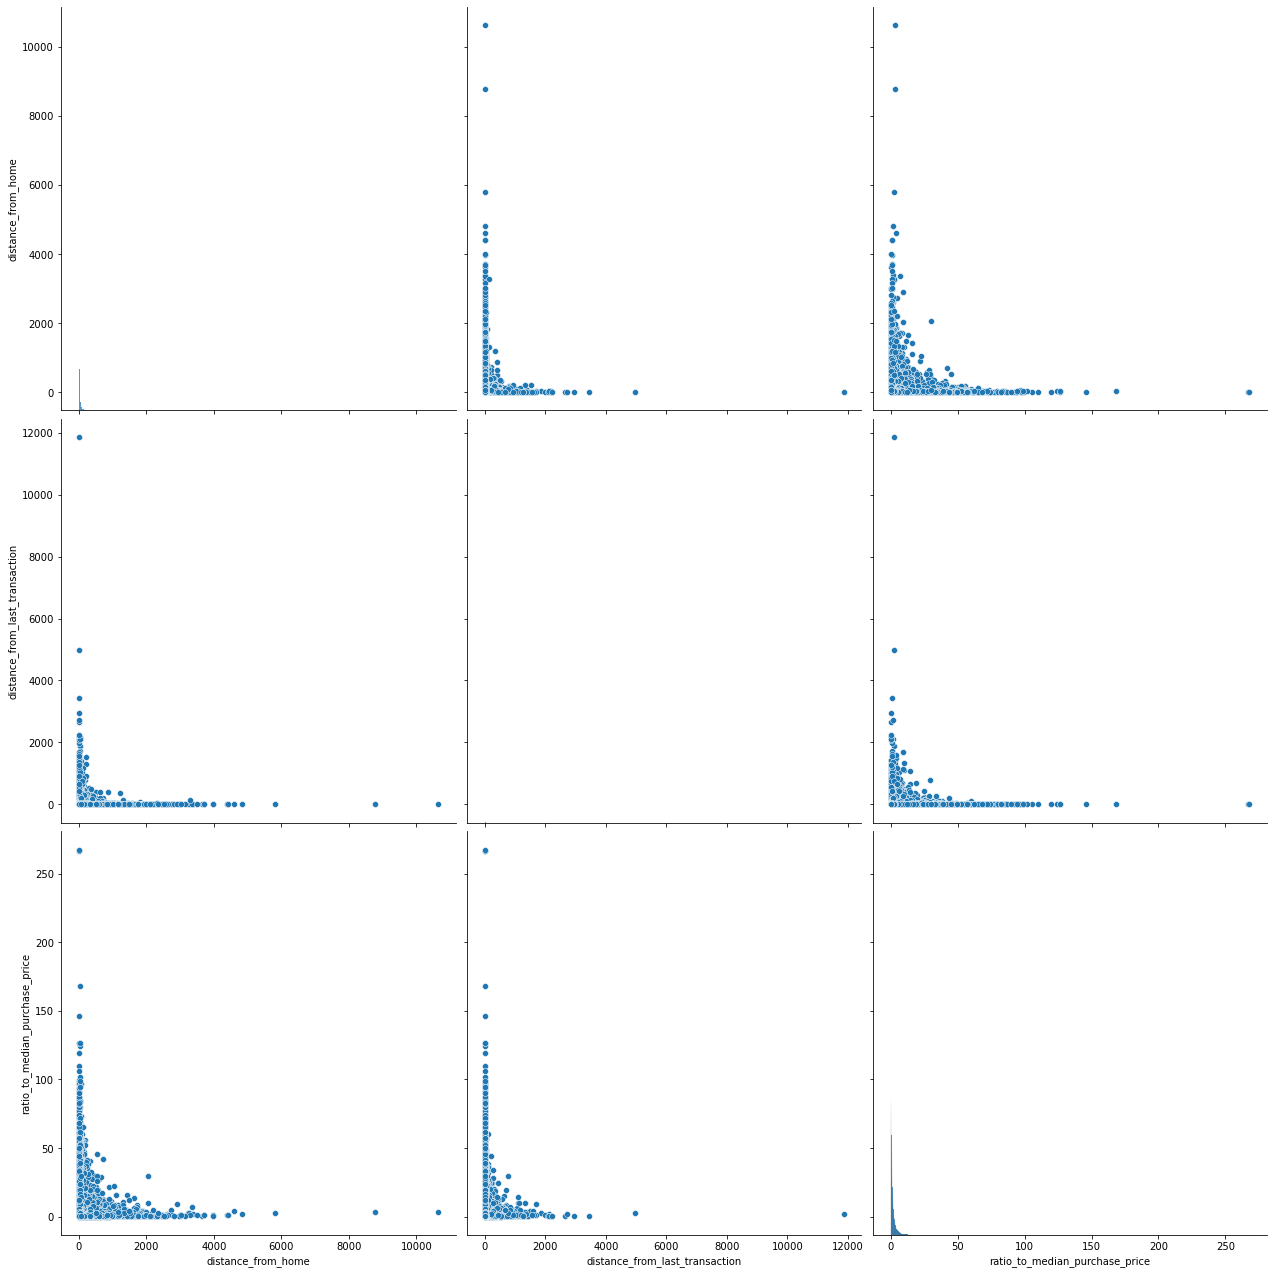

In [8]:
sns.pairplot(data=df[numerical_features], height=6, aspect=1)

<AxesSubplot:xlabel='online_order', ylabel='count'>

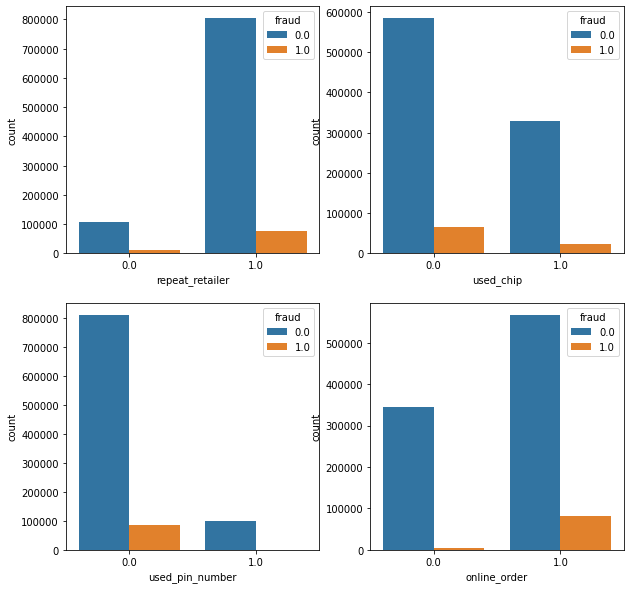

In [6]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize =(10,10))
sns.countplot(ax=axes[0,0],x="repeat_retailer", data=df, hue='fraud')
sns.countplot(ax=axes[0,1],x="used_chip", data=df, hue='fraud')
sns.countplot(ax=axes[1,0],x="used_pin_number", data=df, hue='fraud')
sns.countplot(ax=axes[1,1],x="online_order", data=df, hue='fraud')

<h4> 2.6 Divisão de treino e teste </h4>

In [8]:
X = df.drop('fraud', axis='columns')
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

<h3>3. Modelagem</h3>

<h4>3.2 Decision Tree Classifier</h4>

- Algoritmos baseados em árvores de decisão geram modelos de alta precisão e são robustos em relação a outliers.

- Eles funcionam de forma semelhante a um fluxograma, estabelecendo nós que se relacionam entre si por uma hierarquia. 

- Os nós-folha são os resultados finais e o nó-raiz é um dos atributos do dataset. Os nós são ligados entre regras "se-então", na qual o algoritmo se pergunta acerca de uma regra, uma condição que ditará o caminho a ser seguido na árvore, até chegar a um resultado final. 

- O algoritmo realiza cálculos que definem a posição de cada variável na árvore com base no ganho de informação e a entropia.

In [18]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
predictions = decision_tree_model.predict(X_test)

In [19]:
accuracy_score(y_test, predictions)

0.999988

A acurácia do modelo já apresenta um valor alto, mas a fim de explorar com mais profundidade os resultados, iremos analisar a matriz de confusão e o classification report.

In [26]:
cm = confusion_matrix(y_test, predictions)
cm

array([[228257,      1],
       [     2,  21740]], dtype=int64)

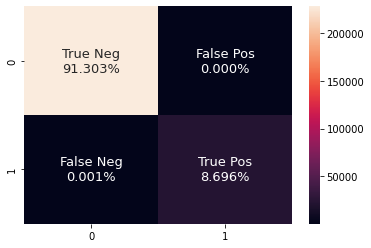

In [131]:
groups = ['True Neg','False Pos','False Neg','True Pos']
percentage_values = ['{0:.3%}'.format(value) for value in cm.flatten() / np.sum(cm)]

labels = [f"{a}\n{b}" for a, b in zip(groups, percentage_values)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, annot_kws={'fontsize':13}, fmt='');

In [33]:
print(classification_report(y_test, predictions, target_names=['Não há fraude', 'Há fraude']))

               precision    recall  f1-score   support

Não há fraude       1.00      1.00      1.00    228258
    Há fraude       1.00      1.00      1.00     21742

     accuracy                           1.00    250000
    macro avg       1.00      1.00      1.00    250000
 weighted avg       1.00      1.00      1.00    250000



In [132]:
def generate_feature_importance(model, X, y):
    return permutation_importance(model, X, y, n_repeats=10, random_state=0)

def info_feature_importance(model, X_test, y_test):
    feature_importance = generate_feature_importance(model, X_test, y_test)

    column_names = X_test.columns
    result = pd.Series(feature_importance.importances_mean, index=column_names)
    print(result.sort_values(ascending=False))

Analisando a importância de cada feature, podemos observar que nenhuma feature está impactando negativamente o modelo e que a variável "ratio_to_median_purchase_price", que determina a razão entre a transação mediana e a atual, é a que mais tem influência sob o modelo, seguida da informação de se a transação foi online e a distância da casa do dono do cartão.

A partir disso, podemos concluir que valores de compras muito diferentes do usual têm mais chances de indicar uma fraude, principalmente se essa compra for online ou de uma localização muito distante de onde o comprador mora.

In [39]:
info_feature_importance(decision_tree_model, X_test, y_test)

ratio_to_median_purchase_price    0.111726
online_order                      0.051678
distance_from_home                0.039662
used_pin_number                   0.017146
used_chip                         0.016556
distance_from_last_transaction    0.011570
repeat_retailer                   0.000516
dtype: float64


Por fim, analisaremos uma representação gráfica da árvore de decisão gerada com os dados do dataset, a fim de validar as conclusões obtidas.

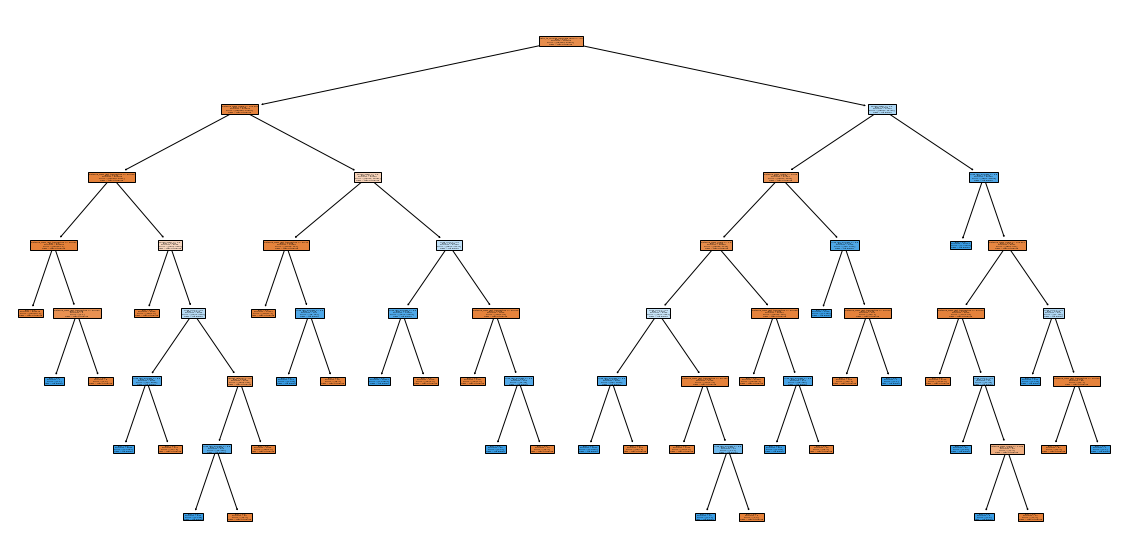

In [81]:
fig = plt.figure(figsize=(20, 10))

plot_tree(decision_tree_model, 
            filled=True,
            feature_names=X.columns,
            class_names=['Não há fraude', 'Há fraude'])
plt.show()

A raiz recebe o dataset completo e faz uma pergunta de verdadeiro ou falso. Essa pergunta divide o dataset pelos próximos dois nós. A parcela dos dados que responder a pergunta de forma negativa vai para o nó da direita e o restante (positivo) vai para o nó da esquerda. Esse processo se repete até o final da árvore.

A visualização da representação da árvore confirma as conclusões obtidas anteriormente.

Maiores variações nos valores de transação, compras online e maiores distâncias de casa são os fatores que mais indicam fraudes. 